## 10. Effected of close paired AGN on Scaling relations of galaxy clusters

This notebook studies how the new AGN model that accounts for merger-triggered AGNs impacts the scaling relations of galaxy clusters.

1. Loading data and defining input parameters

**Script written by**: Soumya Shreeram <br>
**Project supervised by**: Johan Comparat <br>
**Date**: 18th June 2021

In [1]:
# astropy modules
import astropy.units as u
import astropy.io.fits as fits

from astropy.table import Table, Column, join
from astropy.coordinates import SkyCoord
from astropy.cosmology import FlatLambdaCDM, z_at_value

import numpy as np

# system imports
import os
import sys
import importlib as ib
import glob

# plotting imports
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm
from scipy import interpolate
import pandas as pd

In [2]:
%matplotlib inline
font = {'family' : 'serif',
        'weight' : 'medium',
        'size'   : 20}
matplotlib.rc('font', **font)

In [3]:
sys.path.append('../imported_files/')
import Exploring_DM_Halos as edh
import Agn_incidence_from_Major_Mergers as aimm
import Comparison_simulation_with_literature_data as cswl
import Scaling_relations as sr
import plotting_sr_agn_clu as pt
import All_sky as sky

In [4]:
# look back into redshifts until...
redshift_limit = 2

# path where the mock catalogues are located
data_dir = os.path.join('/data24s', 'comparat', 'simulation', 'UNIT', 'ROCKSTAR_HALOS',\
         'fixedAmp_InvPhase_001')

# pixel number from the simulation file
pixel_no = '000000'

# pixel number from the simulation file
pixel_no_cont_arr = sky.allPixelNames()

pal = sns.hls_palette(10, h=.5, s=1).as_hex()
sns.set_context("paper", font_scale=2, rc={"lines.linewidth":2})

 # fraction of close pair agns added to the cat_AGN_all
frac_cp_agn = 0.2
if frac_cp_agn == 0.15:
    frac_str = '%.2f'%frac_cp_agn
else:
    frac_str = '%.1f'%frac_cp_agn
# arr to save the changed flux
frac_r500c_arr = [0, .2, 0.5, 1]

# params for deciding which directory to open
tmm_min, tmm_max, xoff_min, xoff_max = 2.3, 2.8, 0.1, 0.13

Define the cosmology used in the notebook

In [5]:
cosmo = FlatLambdaCDM(H0=67.77*u.km/u.s/u.Mpc, Om0=0.307115)
h = 0.6777
L_box = 1000.0 / h

vol = cosmo.comoving_volume(redshift_limit)*(53)/(129600/np.pi)

Loding the halo file

In [6]:
hd_agn, hd_halo, _ = edh.getHeaders(pixel_no, np.array(['agn', 'halo']))
hd_agn = hd_agn[hd_agn['redshift_R']<redshift_limit]
hd_halo = hd_halo[hd_halo['redshift_R']<redshift_limit]

Loading the AGN catalogue

In [7]:
print('The background AGN flux per degree squared for the given pixel:')
sr.getAGNbkgFlux(pixel_no)

The background AGN flux per degree squared for the given pixel:


2.652700453045501e-12

In [11]:
catAGN_dir_name = 'CP_10_sigma_1.0_frac_' + frac_str + '_%.1f_tmm_*_*_xoff_*'%tmm_min
catAGN_dir = glob.glob(os.path.join(data_dir, catAGN_dir_name ))[0]
catAGN_dir_file = os.path.join(data_dir, catAGN_dir, pixel_no+'.fit')
hd_cp_agn = Table.read(catAGN_dir_file, format='fits')
print("CP agn: %d, All agn: %d"%(len(hd_cp_agn), len(hd_agn)))

CP agn: 966051, All agn: 1076520


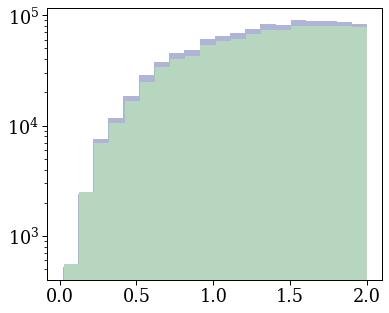

In [12]:
fig, ax = plt.subplots(figsize=(6, 5))

ax.hist(hd_agn['redshift_R'], color='#b0b4d6', bins=20, label='catAGN')
ax.hist(hd_cp_agn['redshift_R'], color='#b6d6bf', bins=20, label='cp_catAGN')
ax.set_yscale('log')
fig.patch.set_facecolor('white')

Loading the cluster catalogue for the same pixel

In [9]:
hd_clu_params = sr.getCluParams(pixel_no)

Test plot of the scaling relations

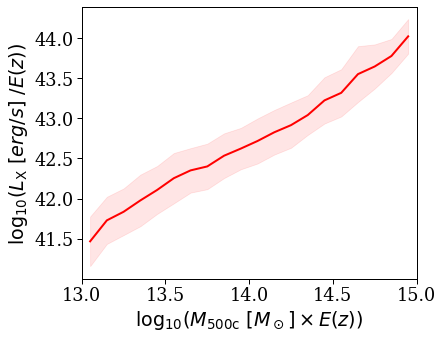

In [24]:
fig, ax = plt.subplots(figsize=(6, 5))
ib.reload(sr)
ib.reload(pt)
ax, xlim = pt.plotBinnedM500cLx(ax, sr.getLogLx(pixel_no), pixel_no=pixel_no, full_sky=False,\
                                ls='-', dlog_M500c=0.1 )
pt.setLabel(ax, r'$\log_{10} ( M_{\rm 500c} \ [M_\odot]\times E(z))$',\
            r'$\log_{10} ( L_{\rm X}\ [erg/s]\ /E(z) )$ ', xlim=xlim, legend=False)
fig.patch.set_facecolor('white')

### Studying these relations for the whole sky

In [14]:
# all sky cluster file
hd_clu_params_all_sky = sky.clusterFileAllSky()
print(len(hd_clu_params_all_sky))

23090625


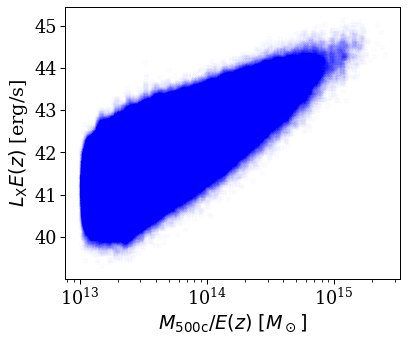

In [38]:
fig, ax = plt.subplots(figsize=(6, 5))
# all sky cluster file
hd_clu_params_all_sky = sky.clusterFileAllSky()

E_z = cosmo.H(hd_clu_params_all_sky['redshift_R'])/cosmo.H(0)
M_500c = hd_clu_params_all_sky['HALO_M500c']
Lx = hd_clu_params_all_sky['CLUSTER_LX_soft_RF']

ax.plot(M_500c*E_z, Lx - np.log10(E_z), 'bX', rasterized = True, alpha=0.01)

pt.setLabel(ax, r'$M_{\rm 500c}/E(z)\ [M_\odot]$', r'$L_{\rm X}E(z)$ [erg/s]', legend=False)
ax.set_xscale('log')
fig.patch.set_facecolor('white')

AGN and cluster distributions

### Finding AGNs neighbouring or within clusters

This section of the notebook looks for AGNs within 0.2, 0.5, 1 and 2 times R500c of clusters. Once these AGNs are found, their flux is added to the cluster and the their impact of the scaling relation is studied.

The following code block creates a SkyCoord object that is inputted into astropy's `search_around_sky`. 

In [10]:
agn_coord = SkyCoord(ra=hd_agn['RA'], dec=hd_agn['DEC'], frame='icrs', unit=(u.deg, u.deg))
agn_cp_coord = SkyCoord(ra=hd_cp_agn_all['RA'], dec=hd_cp_agn_all['DEC'], frame='icrs', unit=(u.deg, u.deg))

cluster_coord = SkyCoord(ra=hd_clu_params['RA'], dec=hd_clu_params['DEC'], frame='icrs', unit=(u.deg, u.deg))

The following code block searches for agn that neighbours clusters. The outputs from `search_around_sky` are as follows:
* `idx_cluster` indicies of the cluster that have an AGN neighbour, whose corresponding index is given in `idx_agn`
*`d2d` array holds the 2D distances between the AGN and the cluster.

In [11]:
# maximum radius to search around the clusters in the given pixel
max_r500c = np.max(hd_clu_params['R500c_arcmin'])*u.arcmin.to(u.deg)

# outputs from the search_around_sky gives the info to mask according to r500c distances 
idx_cluster, idx_agn, d2d, _  = agn_coord.search_around_sky(cluster_coord, max_r500c*u.deg)
idx_cluster_cp, idx_agn_cp, d2d_cp, _  = agn_cp_coord.search_around_sky(cluster_coord, max_r500c*u.deg)

In [32]:
ib.reload(sr)

scaled_LX_soft_RF_agn_all = np.zeros((len(frac_r500c_arr)-1, len(hd_clu_params)))
scaled_LX_soft_RF_cp_agn_all = np.zeros((len(frac_r500c_arr)-1, len(hd_clu_params)))
count_changes_arr, count_cp_changes_arr = [], []
pixel_no = '000000'
for f, frac_r500c in enumerate(frac_r500c_arr[1:]):
    # results that do not account for close pairs
    scaled_LX_soft_RF_agn, count_changes = sr.checkIfAGNfluxinR500c(pixel_no, frac_r500c,\
                                                                    hd_agn, idx_cluster,\
                                                                    idx_agn, d2d)
    scaled_LX_soft_RF_agn_all[f, :] = scaled_LX_soft_RF_agn
    count_changes_arr.append(count_changes)
    
    # results that account for close pairs
    scaled_LX_soft_RF_agn_cp, count_changes_cp = sr.checkIfAGNfluxinR500c(pixel_no, frac_r500c,\
                                                                      hd_cp_agn_all,\
                                                                      idx_cluster_cp,\
                                                                      idx_agn_cp, d2d_cp)
    
    scaled_LX_soft_RF_cp_agn_all[f, :] = scaled_LX_soft_RF_agn_cp
    count_cp_changes_arr.append(count_changes_cp)

Scaling flux if AGN exist inside 0.2 times R_500c
86.6 percent clusters have AGN neighbours
Scaling flux if AGN exist inside 0.2 times R_500c
87.6 percent clusters have AGN neighbours
Scaling flux if AGN exist inside 0.5 times R_500c
99.8 percent clusters have AGN neighbours
Scaling flux if AGN exist inside 0.5 times R_500c
99.8 percent clusters have AGN neighbours
Scaling flux if AGN exist inside 1.0 times R_500c
100.0 percent clusters have AGN neighbours
Scaling flux if AGN exist inside 1.0 times R_500c
100.0 percent clusters have AGN neighbours


In [ ]:
fig, ax = plt.subplots(figsize=(6, 5))
ib.reload(pt)
ib.reload(sr)
pixel_no = '000000'

for i in range(len(scaled_LX_soft_RF_cp_agn_all)):
    label = r'with AGN <%.1f$\times R_{500c}$'%(frac_r500c_arr[i+1])
    ax, _ = pt.plotBinnedM500cLx(ax, scaled_LX_soft_RF_cp_agn_all[i, :], pixel_no=pixel_no,\
                                 c=pal[i], full_sky=False, ls='-', label=label)

ax, xlim = pt.plotBinnedM500cLx(ax, hd_clu_params['CLUSTER_LX_soft_RF'], ls='-' ,\
                                full_sky=False, pixel_no=pixel_no)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14, frameon=False)

for i in range(len(scaled_LX_soft_RF_agn_all)):
    ax, _ = pt.plotBinnedM500cLx(ax, scaled_LX_soft_RF_agn_all[i, :], pixel_no=pixel_no,\
                                 c=pal[i], full_sky=False)

fig.patch.set_facecolor('white')
pt.setLabel(ax, r'$\log_{10}\ M_{\rm 500c}\ [M_\odot]\times E(z)$', r'$\log_{10}\ L_{\rm X}/E(z)\ [erg/s] $ ',\
            title=r'$f_{\rm cp\ AGN}$ = %.2f %s'%(100*frac_cp_agn, '%'), xlim=xlim, legend=False)

pt.saveFig('agn_sr0_z%.1f_frac_cp_agn%.2f_meanLx.png'%(redshift_limit, frac_cp_agn))

print('Number of AGNs found in each bin:', count_changes_arr)
print('Number of AGNs found in each bin:', count_cp_changes_arr)

In [ ]:
fig, ax = plt.subplots(figsize=(6, 5))
ib.reload(pt)
ib.reload(sr)
pixel_no = '000000'

for i in range(len(scaled_LX_soft_RF_cp_agn_all)):
    label = r'with AGN <%.1f$\times R_{500c}$'%(frac_r500c_arr[i+1])
    ax, _ = pt.plotBinnedM500cLx(ax,\
                                 scaled_LX_soft_RF_cp_agn_all[i, :]/hd_clu_params['CLUSTER_LX_soft_RF'],\
                                 pixel_no=pixel_no, c=pal[i], full_sky=False, ls='-', label=label)
"""
ax, xlim = pt.plotBinnedM500cLx(ax, , ls='-' ,\
                                full_sky=False, pixel_no=pixel_no)

"""
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14, frameon=False)

for i in range(len(scaled_LX_soft_RF_agn_all)):
    ax, _ = pt.plotBinnedM500cLx(ax, scaled_LX_soft_RF_agn_all[i, :]/hd_clu_params['CLUSTER_LX_soft_RF'],\
                                 pixel_no=pixel_no, c=pal[i], full_sky=False)

fig.patch.set_facecolor('white')
pt.setLabel(ax, r'$\log_{10}\ M_{\rm 500c}\ [M_\odot]\times E(z)$', r'$\log_{10}\ L_{\rm X}/E(z)\ [erg/s] $ ',\
            title=r'$f_{\rm cp\ AGN}$ = %.2f %s'%(100*frac_cp_agn, '%'), xlim=xlim, legend=False)

pt.saveFig('agn_scatter_sr0_z%.1f_frac_cp_agn%.2f_meanLx.png'%(redshift_limit, frac_cp_agn))

print('Number of AGNs found in each bin:', count_changes_arr)
print('Number of AGNs found in each bin:', count_cp_changes_arr)

mean scatter/std: 0.009950216169561503
mean scatter/std: 0.010322512497772928
mean scatter/std: 0.010945359780269141
Number of AGNs found in each bin: [10258, 58757, 228714]
Number of AGNs found in each bin: [10650, 60589, 235503]


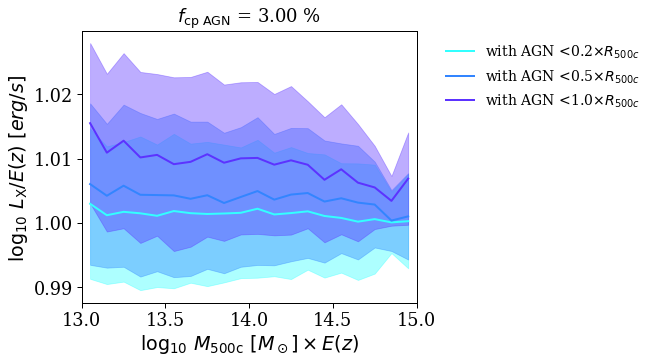

In [27]:
fig, ax = plt.subplots(figsize=(6, 5))
ib.reload(pt)
ib.reload(sr)
pixel_no = '000000'

for i in range(3):
    label = r'with AGN <%.1f$\times R_{500c}$'%(frac_r500c_arr[i+1])
    ax, _ = pt.plotBinnedM500cLxScatter(ax,\
                                 scaled_LX_soft_RF_cp_agn_all[i, :], hd_clu_params['CLUSTER_LX_soft_RF'],\
                                 pixel_no=pixel_no, c=pal[i], full_sky=False, ls='-', label=label)

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14, frameon=False)

fig.patch.set_facecolor('white')
pt.setLabel(ax, r'$\log_{10}\ M_{\rm 500c}\ [M_\odot]\times E(z)$', r'$\log_{10}\ L_{\rm X}/E(z)\ [erg/s] $ ',\
            title=r'$f_{\rm cp\ AGN}$ = %.2f %s'%(100*frac_cp_agn, '%'), xlim=xlim, legend=False)

pt.saveFig('agn_scatter_sr0_z%.1f_frac_cp_agn%.2f_meanLx.png'%(redshift_limit, frac_cp_agn))

print('Number of AGNs found in each bin:', count_changes_arr)
print('Number of AGNs found in each bin:', count_cp_changes_arr)

Understanding the use of percentile deviation vs standard deviation

sigma Gaussian 2.953791234005198
sigma percentile 2.8726743349246693


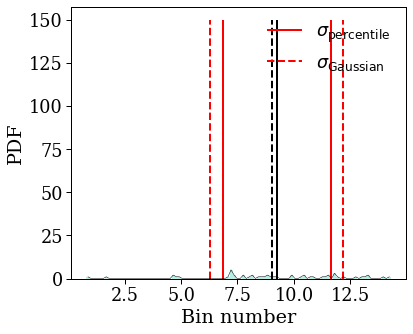

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

a = np.random.normal(10, 3, 50)

counts, bin_edges, _ = ax.hist(a, 100, color='#6fdecf', alpha=0.5)
ax.plot((bin_edges[1:]+bin_edges[:-1])/2, counts, 'k-', lw=0.5)

# plots the mean
mean_counts = np.mean(a)
ax.vlines(mean_counts, 0, 150, colors='k')

# two possibilities for std
sigma_percentile = (np.percentile(a, 84.13)-np.percentile(a, 15.87))/2
sigma_gaussian = np.std(a)

ax.vlines(mean_counts+sigma_percentile, 0, 150, colors='r', label=r'$\sigma_{\rm percentile}$')
ax.vlines(mean_counts+sigma_gaussian, 0, 150, colors='r', linestyles='--', label=r'$\sigma_{\rm Gaussian}$')

ax.vlines(mean_counts-sigma_percentile, 0, 150, colors='r')
ax.vlines(mean_counts-sigma_gaussian, 0, 150, colors='r',  linestyles='--')
ax.vlines(np.percentile(a, 50), 0, 150, colors='k',  linestyles='--')

print('sigma Gaussian', np.std(a))
print('sigma percentile', np.percentile(a, 68.2)-np.percentile(a, 34.1))

ax.legend(frameon=False)
pt.setLabel(ax, 'Bin number', 'PDF', legend=False)

fig.patch.set_facecolor('white')

### Whole sky results

In [9]:
make_clu_file = False
model_name = 'Model_A0'
frac_cp_agn = 0.2
model_dir = '../Data/pairs_z%.1f/Scaling_relations/%s/'%(redshift_limit, model_name)

In [10]:
if make_clu_file:
    ib.reload(sky)
    # refer to script 012_[...].py that does this for all models+fractions
    hd_clu_params_all = sky.makeClusterFile(redshift_limit=2, model_name=model_name)
    fname = model_dir+'CLU_with_scaled_Lx_all_sky_%.2f.fit'%(frac_cp_agn)
    hd_clu_params_all.write(fname, format='fits')
else:
    fname = model_dir+'CLU_with_scaled_Lx_all_sky_frac_cp_%.2f.fit'%(frac_cp_agn)
    hd_clu_params_all_model = Table.read(fname, format='fits')
    
    fname = '../Data/pairs_z%.1f/Scaling_relations/CLU_with_scaled_Lx_all_sky_%s.fit'%(redshift_limit, 'ModelNone')
    hd_clu_params_all_og = Table.read(fname, format='fits')

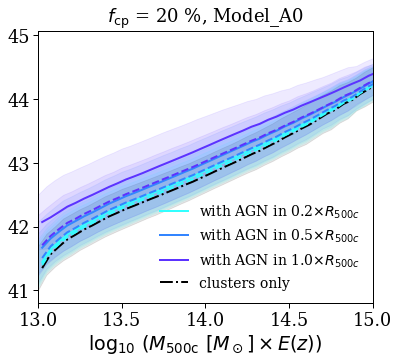

In [15]:
fig, ax = plt.subplots(figsize=(6, 5))
ib.reload(sr)
ib.reload(pt)
names = ['f_AGN_(%.1f-%.1f)R_500c'%(frac_r500c_arr[i], f) for i, f in enumerate(frac_r500c_arr[1:])]

for i, n in enumerate(names):
    label = r'with AGN in %.1f$\times R_{500c}$'%(frac_r500c_arr[i+1])
    
    ax, _ = pt.plotBinnedM500cLx(ax, hd_clu_params_all_model[n], c=pal[i],\
                                 label=label, model_name=model_name, frac_cp=frac_cp_agn)
    
ax.legend(loc='lower right', fontsize=14, frameon=False)
ax, _ = pt.plotBinnedM500cLx(ax,  hd_clu_params_all_og['CLUSTER_LX_soft_RF'], ls='-.', \
                            model_name='ModelNone')
ax.legend(loc='lower right', fontsize=14, frameon=False)

for i, n in enumerate(names):
    ax, _ = pt.plotBinnedM500cLx(ax, hd_clu_params_all_og[n], c=pal[i], ls='--', \
                                model_name='ModelNone')
    
    # r'$\log_{10}\ \rm (L_{\rm X}[erg/s]\ /E(z)\  ) $ '
fig.patch.set_facecolor('white')
pt.setLabel(ax, r'$\log_{10}\ (M_{\rm 500c}\ [M_\odot]\times E(z))$',\
            '',\
            title=r'$f_{\rm cp}$ = %d %s, %s'%(100*frac_cp_agn, '%', model_name),\
            legend=False, xlim=[13.0, 15.])

pt.saveFig('frame_all.png')

with AGN models
---- f_AGN_(0.0-0.2)R_500c ----
[13.   13.15 13.3  13.45 13.6  13.75 13.9  14.05 14.2  14.35 14.5  14.65
 14.8  14.95 15.1  15.25] 16
[41.69240177 41.95730607 42.16847422 42.35251675 42.51284725 42.67656889
 42.84470315 43.0229616  43.19985515 43.3850762  43.5802164  43.7880132
 43.99830422 44.24655959 44.4912782  44.52145188]
---- f_AGN_(0.2-0.5)R_500c ----
[13.   13.15 13.3  13.45 13.6  13.75 13.9  14.05 14.2  14.35 14.5  14.65
 14.8  14.95 15.1  15.25] 16
[41.85858302 42.09433697 42.29482063 42.47498559 42.63540316 42.79928974
 42.96696538 43.14414208 43.31748745 43.49664383 43.68108595 43.87407013
 44.0679327  44.30200309 44.51992062 44.53928618]
---- f_AGN_(0.5-1.0)R_500c ----
[13.   13.15 13.3  13.45 13.6  13.75 13.9  14.05 14.2  14.35 14.5  14.65
 14.8  14.95 15.1  15.25] 16
[42.18351013 42.37949813 42.56350565 42.73610826 42.89429455 43.056279
 43.22074106 43.39075194 43.55480089 43.7196777  43.88362772 44.048126
 44.21406059 44.4181704  44.60002625 44.61087807]

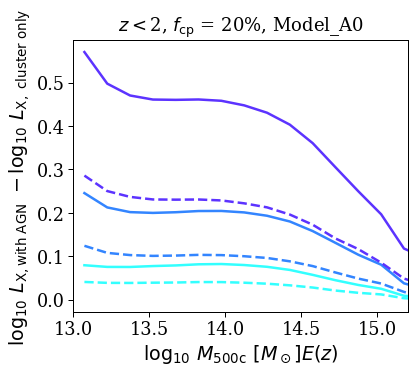

In [24]:
fig, ax = plt.subplots(figsize=(6, 5))
ib.reload(sr)
ib.reload(pt)
names = ['f_AGN_(%.1f-%.1f)R_500c'%(frac_r500c_arr[i], f) for i, f in enumerate(frac_r500c_arr[1:])]

delta_Lx_model, delta_Lx = [], []
print('with AGN models')
for i, n in enumerate(names):
    print('----', n, '----')
    label = r'with AGN in %.1f$\times R_{500c}$'%(frac_r500c_arr[i+1])
    if i == 0:
        plot_label = True
    else:
        plot_label = False
    ax, _, delta_Lx_model_temp = pt.plotBinnedM500cLxDifference(ax, hd_clu_params_all_model[n],\
                                        hd_clu_params_all_og['CLUSTER_LX_soft_RF'], c=pal[i], \
                                       label=label)
    delta_Lx_model.append(delta_Lx_model_temp)
#ax.legend(loc='upper left', fontsize=14, frameon=False)

print('without AGN models') 
for i, n in enumerate(names):
    label = r'with AGN in %.1f$\times R_{500c}$'%(frac_r500c_arr[i+1])
    ax, _, delta_Lx_temp = pt.plotBinnedM500cLxDifference(ax, hd_clu_params_all_og[n],\
                                        hd_clu_params_all_og['CLUSTER_LX_soft_RF'], c=pal[i], \
                                       label=label, ls='--')
    delta_Lx.append(delta_Lx_temp)
    
fig.patch.set_facecolor('white')
xl = r'$\log_{10}\ M_{\rm 500c}\ [M_\odot] E(z)$'
yl = r'$\log_{10}\ L_{\rm X, with\ AGN}\ - \log_{10}\ L_{\rm X,\ cluster\ only}$ '
t = r'$z<$%d, $f_{\rm cp}$ = %d%s, %s'%(redshift_limit, 100*frac_cp_agn, '%', model_name)
#t = 'Difference with respect to cluster luminosities'
pt.setLabel(ax, xl, yl, title=t, xlim=[13.0, 15.2], legend=False)

pt.saveFig('differences.png')

In [28]:
print(42.18351013-41.89892505)
print(delta_Lx_model_temp - delta_Lx_temp)
delta_Lx_model[2]-delta_Lx[2]

0.2845850799999994
[0.28458509 0.24749571 0.23360594 0.23014782 0.22993293 0.23040006
 0.2295629  0.22567837 0.21800312 0.20705188 0.18789833 0.16395
 0.13320319 0.11147884 0.06915139 0.06287003]


array([0.28458509, 0.24749571, 0.23360594, 0.23014782, 0.22993293,
       0.23040006, 0.2295629 , 0.22567837, 0.21800312, 0.20705188,
       0.18789833, 0.16395   , 0.13320319, 0.11147884, 0.06915139,
       0.06287003])

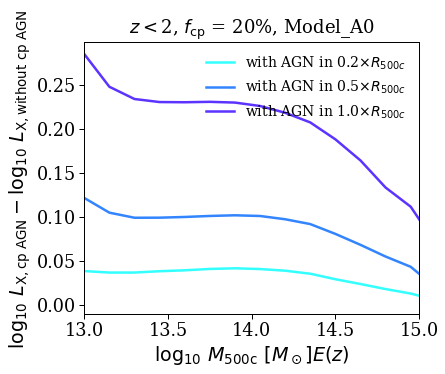

In [32]:
fig, ax = plt.subplots(figsize=(6, 5))
ib.reload(sr)
ib.reload(pt)

for i, n in enumerate(names):
    label = r'with AGN in %.1f$\times R_{500c}$'%(frac_r500c_arr[i+1])
    x = np.arange(13, 15.35, 0.15)
    y = delta_Lx_model[i]-delta_Lx[i]
    ax.plot(x, y, c=pal[i], lw=2.5, label=label)
ax.legend(loc='upper right', fontsize=14, frameon=False)

fig.patch.set_facecolor('white')
xl = r'$\log_{10}\ M_{\rm 500c}\ [M_\odot] E(z)$'
yl = r'$\log_{10}\ L_{\rm X, cp\ AGN} - \log_{10}\ L_{\rm X, without\ cp\ AGN} $ '
#t = r'$z<$%d, $f_{\rm cp}$ = %d%s, %s'%(redshift_limit, 100*frac_cp_agn, '%', model_name)
t = r'$z<$%d, $f_{\rm cp}$ = %d%s, %s'%(redshift_limit, 100*frac_cp_agn, '%', model_name)
pt.setLabel(ax, xl, yl, title=t, xlim=[13.0, 15.], legend=False)

pt.saveFig('differences_between_cats.png')

with AGN models
---- f_AGN_(0.0-0.2)R_500c ----
groups: 0.078 +/- 0.002
clusters: 0.044 +/- 0.026
---- f_AGN_(0.2-0.5)R_500c ----
groups: 0.210 +/- 0.015
clusters: 0.123 +/- 0.062
---- f_AGN_(0.5-1.0)R_500c ----
groups: 0.482 +/- 0.038
clusters: 0.289 +/- 0.125
without AGN models
groups: 0.039 +/- 0.001
clusters: 0.021 +/- 0.013
groups: 0.106 +/- 0.008
clusters: 0.059 +/- 0.033
groups: 0.242 +/- 0.019
clusters: 0.136 +/- 0.066


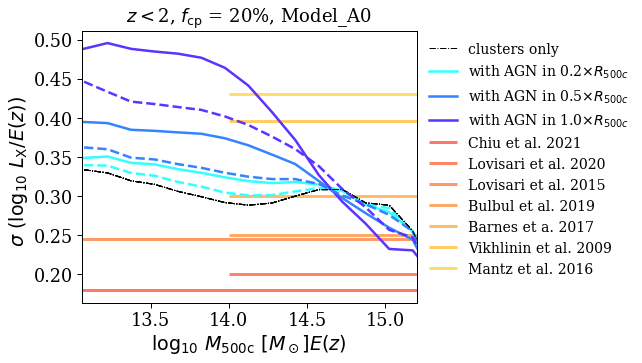

In [44]:
fig, ax = plt.subplots(figsize=(6, 5))
ib.reload(pt)
ib.reload(sr)
pixel_no = '000000'

papers = ['Chiu et al. 2021', 'Lovisari et al. 2020', 'Lovisari et al. 2015', 'Bulbul et al. 2019', 'Barnes et a. 2017', 'Vikhlinin et al. 2009','Mantz et al. 2016']
scatters = [0.18, 0.2, 0.245, 0.25, 0.3, 0.396, 0.43]
mass_lower_limits = [13, 14, 13, 14, 14, 14, 14]
greys = sns.color_palette("autumn", len(papers)+1)

for i,y in enumerate(scatters):
    ax.hlines(y, mass_lower_limits[i], 15.2, colors=greys[i], linestyles='-', alpha=0.6, label=papers[i], zorder=1, linewidths=3)

print('with AGN models')
for i, n in enumerate(names):
    print('----', n, '----')
    label = r'with AGN in %.1f$\times R_{500c}$'%(frac_r500c_arr[i+1])
    if i == 0:
        plot_label = True
    else:
        plot_label = False
    ax, _ = pt.plotBinnedM500cLxScatter(ax, hd_clu_params_all_model[n],\
                                        hd_clu_params_all_og['CLUSTER_LX_soft_RF'], c=pal[i], \
                                       label=label, plot_label=plot_label)

ax.legend(bbox_to_anchor=(1, 0.05), loc='lower left', fontsize=14, frameon=False)

print('without AGN models') 
for i, n in enumerate(names):
    label = r'with AGN in %.1f$\times R_{500c}$'%(frac_r500c_arr[i+1])
    ax, _ = pt.plotBinnedM500cLxScatter(ax, hd_clu_params_all_og[n],\
                                        hd_clu_params_all_og['CLUSTER_LX_soft_RF'], c=pal[i], \
                                       label=label, ls='--')

    
fig.patch.set_facecolor('white')
xl = r'$\log_{10}\ M_{\rm 500c}\ [M_\odot] E(z)$'
yl = r'$\sigma\ (\log_{10}\ L_{\rm X}/ E(z))\ $ '
t = r'$z<$%d, $f_{\rm cp}$ = %d%s, %s'%(redshift_limit, 100*frac_cp_agn, '%', model_name)
pt.setLabel(ax, xl, yl, title=t, xlim=[13.06, 15.2], legend=False)

pt.saveFig('agn_scatter_z%.1f_f_cp_%.2f_%s.png'%(redshift_limit, frac_cp_agn, model_name))

Checking the distribution of Lx in every mass bin

In [178]:
tot_num_changed_clusters = np.zeros((0, 3))
count_changes = 0
dir_name = '../Data/pairs_z%.1f/Scaling_relations/%s/'%(redshift_limit, model_name)
for pix_start, pix_stop in zip(sr.pixelEndpoints()[:-1], sr.pixelEndpoints()[1:]-1):
    fname = 'Changed_Lx_%s_px_%s.npy'%(pixel_no_cont_arr[pix_start], pixel_no_cont_arr[pix_stop])
    num_changed_clusters = np.load(dir_name+fname, allow_pickle=True)
    print(num_changed_clusters)
    count_changes += len(num_changed_clusters)
    tot_num_changed_clusters = np.vstack([tot_num_changed_clusters, num_changed_clusters])

[[ 535.  974. 1368.]]
[[1081. 1909. 2753.]]
[[1509. 2570. 3899.]]
[[ 931. 1656. 2404.]]
[[1312. 2345. 3417.]]
[[ 952. 1746. 2514.]]
[[1071. 1848. 2717.]]
[[ 865. 1554. 2235.]]
[[ 809. 1507. 2148.]]
[[1202. 2073. 3054.]]
[[1097. 1962. 2832.]]
[[ 866. 1516. 2180.]]
[[ 698. 1257. 1771.]]
[[ 751. 1357. 1936.]]
[[1146. 2013. 2905.]]
[[ 969. 1727. 2465.]]


In [50]:
l = sr.checkLxDist(hd_clu_params_all['CLUSTER_LX_soft_RF'],\
                   full_sky=True, dlog_M500c=0.05)
log_M500c_bins, dlog_M500c, log_Lx_every_M500c = l  

Total clusters all sky: 2668009


Ignoring all mass bins from 14.9 - 15.3


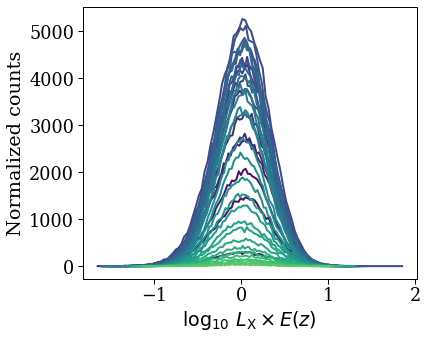

In [25]:
fig, ax = plt.subplots(figsize=(6, 5))
blues = sns.color_palette("viridis", 50)
print('Ignoring all mass bins from %.1f - %.1f'%(log_M500c_bins[-9], log_M500c_bins[-1]))
num_bins = 100
Lx_2D = np.zeros((len(log_M500c_bins[:-9]), num_bins))

for i, Lx in enumerate(log_Lx_every_M500c[:-9]):
    Lx = np.array(Lx)
    
    Lx_counts, Lx_bins = np.histogram(Lx-np.median(Lx), bins=num_bins)
    Lx_counts = Lx_counts#/np.max(Lx_counts)
    ax.plot(Lx_bins[1:], Lx_counts, '-', color=blues[i])
    Lx_2D[i, :] = Lx_counts
    
fig.patch.set_facecolor('white')
yl = 'Normalized counts'
xl = r'$\log_{10}\ L_{\rm X}\times E(z) $ '
#t = r'$f_{\rm cp\ AGN}$ = %.2f %s, %s'%(100*frac_cp_agn, '%', model_name)
pt.setLabel(ax, xl, yl, legend=False)
#ax.set_yscale('log')
pt.saveFig('histLx_%s.png'%model_name)

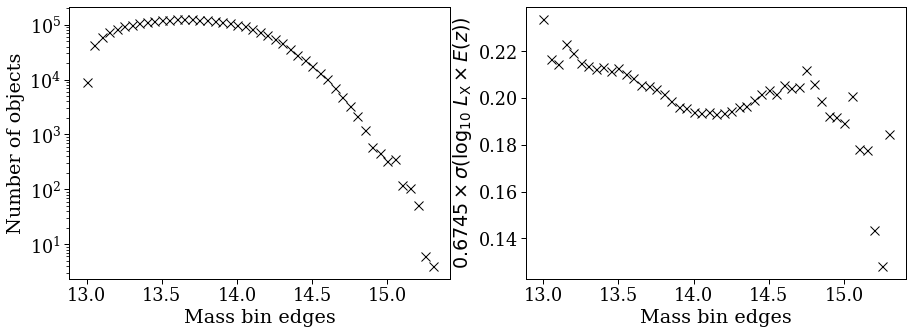

In [64]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

get_Lx_lens, get_Lx_std = [], []
for Lx in log_Lx_every_M500c:
    get_Lx_lens.append(len(Lx))
    get_Lx_std.append(np.std(Lx))

ax[0].plot(log_M500c_bins, get_Lx_lens, 'kx', ms=9)
ax[1].plot(log_M500c_bins, np.array(get_Lx_std)*0.6745, 'kx', ms=9)
fig.patch.set_facecolor('white')

pt.setLabel(ax[0], 'Mass bin edges', 'Number of objects', legend=False)
pt.setLabel(ax[1], 'Mass bin edges', r'$0.6745\times \sigma(\log_{10}\ L_{\rm X}\times E(z))$', legend=False)
ax[0].set_yscale('log')
pt.saveFig('number_of_objects.png')

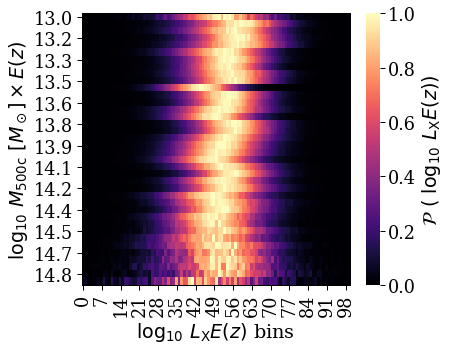

In [21]:
fig, ax = plt.subplots(1,1,figsize=(6,5))

mass_bins_dec = [i+(j-i)/2 for i, j in zip(log_M500c_bins[:-1], log_M500c_bins[1:])]
mass_bins_dec= ['%.1f'%t for t in log_M500c_bins[:-9]]


df = pd.DataFrame(Lx_2D, index=mass_bins_dec)
ax = sns.heatmap(df, cbar_kws={'label': r'$\mathcal{P}\ (\ \log_{10}\ L_{\rm X}E(z))$'}, cmap='magma')

# make frame visible
for _, spine in ax.spines.items():
    spine.set_visible(True)

yl = r'$\log_{10}\ M_{\rm 500c}\ [M_\odot]\times E(z)$'
xl = r'$\log_{10}\ L_{\rm X}E(z)$ bins '
pt.setLabel(ax, xl,yl,legend=False)
fig.patch.set_facecolor('white')
pt.saveFig('heat_map_Lx_dist.png')

### Get percentile scatter

In [ ]:
std_Lx = (np.percentile(Lx, 68.26) - np.percentile(Lx, 34.13))/2